In [1]:
root_path = "/home/katanovic/fluid_kinetic_class/"
phare_path = "/home/katanovic/PHARE/"

import os
import sys

phare_root = os.path.expanduser(phare_path)
sys.path.append(os.path.join(phare_path, "pyphare"))
sys.path.append(os.path.join(root_path, "2024"))

import matplotlib.pyplot as plt
import numpy as np
import scipy as sc
from numpy import polyfit
from pyphare.pharesee.hierarchy import fromh5  # was get_times_from_h5
from pyphare.pharesee.run import Run
from scipy.ndimage import gaussian_filter1d as gf
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from scripts import dist_plot

sys.path.append("/home/katanovic/fluid_kinetic_class/2024/nb")
from get_get import *

%matplotlib widget

root_path = "/home/katanovic/fluid_kinetic_class/2024/run/beam/"

In [2]:
path = root_path + "ib1"
r = Run(path)

In [3]:
def get_Te(r, t, sigma = 2):
    a, b = r.GetTe(t, merged=True)
    return a, b

In [4]:
time = 0

In [5]:
a, b = get_Te(r, time)

['__bool__', '__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__']


RuntimeError: Failed to deserialize simulation from data file : No module named 'numpy._core'

In [ ]:
print(a, b)

Text(0.5, 0, 'Time')

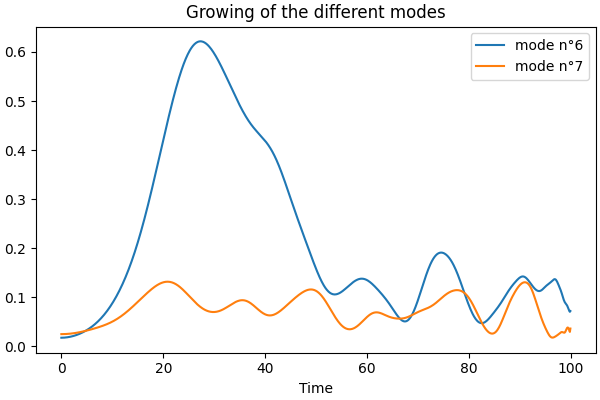

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), constrained_layout=True)

for i in range(5,7):
    mode, times = modes_E(path, i)
    ax.plot(times, mode, label=f"mode n°{i+1}")

ax.legend()
ax.set_title("Growing of the different modes")
ax.set_xlabel("Time")

In [4]:
def gamma_Ex(run_path, i):
    file = os.path.join(run_path, "EM_B.h5")
    times = fromh5.get_times_from_h5(file)
    dt = times[1] - times[0]
    r = Run(run_path)
    first_mode = np.array([])

    for time in times:
        E_hier = r.GetE(time, merged=True, interp="nearest") #Was linear

        ex_interpolator, xyz_finest = E_hier["Ex"]

        # remove the last point so that "x" is periodic wo. last point = first point
        x = xyz_finest[0][:-1]

        ex = ex_interpolator(x)

        # get the mode 1, as it is the most unstable in a box of length 33
        mode = np.absolute(np.fft.fft(ex)[i+1])
        first_mode = np.append(first_mode,mode)
    tmax = np.argmax(first_mode)
    xmax = first_mode[tmax]

    first_mode = first_mode[:tmax]
    times = times[:tmax]

    popt, pcov = curve_fit(yaebx, times[: tmax], first_mode, p0=[0.08, 0.09])
    a, b = popt
    
    return a, b, times

In [5]:
alpha = []
g = []
for i in range(10):
    a, b, times = gamma_Ex(path, i)
    alpha.append(a)
    g.append(b)

In [6]:
k = np.arange(1, i+2, 1)
k = k*2*np.pi/r.GetDomainSize()[0]

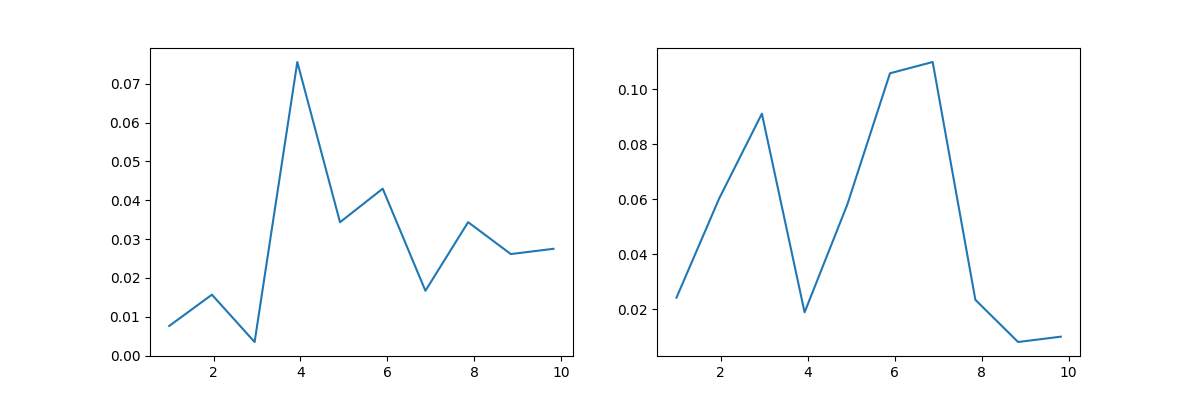

In [7]:
fig, ax = plt.subplots(1,2, figsize =(12,4))

ax[0].plot(k, alpha)
ax[1].plot(k, g)

In [8]:
W = []
km = 5 #Max 15 for the moment
k = np.arange(1, km+1, 1)
k = k*2*np.pi/r.GetDomainSize()[0]

for i in range(km): 
    times, first_mode, ampli, gam, damped_mode, omega = growth_b_right_hand(r.path, 0, i)
    W.append(omega)
print("$\omega_1$ = ", W[0], "$k_1$ = ", k[0], "$v_{\phi}$ = ", k[0]/W[0])

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
def growth_b_left_hand(r, run_path,**kwargs):
    time_offset = 0
    file = os.path.join(run_path, "EM_B.h5")
    times = fromh5.get_times_from_h5(file)
    dt = times[1] - times[0]
    r = Run(run_path)
    first_mode = np.array([])

    for time in times:
        B_hier = r.GetB(time, merged=True, interp="linear")

        by_interpolator, xyz_finest = B_hier["By"]
        bz_interpolator, xyz_finest = B_hier["Bz"]
        
        x = xyz_finest[0][:-1]

        by = by_interpolator(x)
        bz = bz_interpolator(x)

        mode1 = np.absolute(np.fft.fft(by + 1j * bz)[4])
        first_mode = np.append(gf(first_mode,20), mode1)


    ioffset = int(time_offset / dt)
    imax = find_peaks(first_mode, width=ioffset)[0][0]

    popt, pcov = curve_fit(yaebx, times[: imax - ioffset], first_mode[: imax - ioffset], p0=[0.08, 0.09])
    ampl, gamma = popt

    damped_mode = first_mode[: imax - ioffset] * yaebx(times[: imax - ioffset], 1 / popt[0], -popt[1])

    omegas = np.fabs(np.fft.fft(damped_mode).real)
    omega = (0.5 * (omegas[1 : omegas.size // 2].argmax() + 1) * 2 * np.pi / times[imax - 1 - ioffset])
    
    fig, ax1 = plt.subplots(1, 1, figsize=(6, 4), constrained_layout=True)

    ax1.set_title("Time evolution of the first right-hand circular mode amplitude")
    ax1.plot(
        times,
        first_mode,
        color="k",
        label="|$\hat{E}_y$|",
    )
    ax1.plot(
        times[:imax],
        yaebx(times[:imax], ampl, gamma),
        color="r",
        linestyle="-",
        label="$E_0. \exp(\gamma t), \ with\ \gamma =${:5.5f} (expected 0.09)".format(
            gamma
        ),
    )
    ax1.axvline(0, 0, yaebx(times[imax], ampl, gamma), color="red", linestyle="--")
    ax1.axvline(
        times[imax] - time_offset,
        0,
        yaebx(times[imax], ampl, gamma),
        color="red",
        linestyle="--",
    )
    ax1.legend()
    ax1.set_xlabel("t - Time")

    return times, first_mode, ampl, gamma, damped_mode, omega

In [ ]:
times, first_mode, ampl, gamma, dampe_mode, omega = growth_b_left_hand(r, path)

In [ ]:
def modes_Ni(run_path, i):
    file = os.path.join(run_path, "ions_density.h5")
    times = fromh5.get_times_from_h5(file)  # Was get_times_from_h5 #Was none
    dt = times[1] - times[0]
    r = Run(run_path)
    modes = np.array([])
    for time in times:
        Ni_hier = r.GetNi(time, merged=True, interp="linear") #Was linear

        ni_interpolator, xyz_finest = Ni_hier["rho"]

        # remove the last point so that "x" is periodic wo. last point = first point
        x = xyz_finest[0][:-1]

        ni = ni_interpolator(x)

        # get the mode 1, as it is the most unstable in a box of length 33
        mode = np.absolute(np.fft.fft(ni)[i+1])
        modes = np.append(modes,mode)
    return modes, times

In [ ]:
fig, ax = plt.subplots(1,1)
for i in range(10):
    mode, times = modes_Ni(r.path, i)
    ax.plot(times, mode)

In [ ]:
time = 50



In [ ]:
main = r.GetParticles(time, ["main"])
beam = r.GetParticles(time, ["beam"])
both = r.GetParticles(time, ["main", "beam"])

In [ ]:
dex, dey, dez, x = get_potentiel(r, times)
ex, ey, ez, x = get_E(r, times)
k = 2*np.pi/(r.GetDomainSize()[0])
print(k)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8,6))

ax.plot(x, dex, label="dex")
ax.plot(x, dey,'.', label="dey")
ax.plot(x, dez, '--', label="dez")
ax.plot(x, -ex/k, 'black', label="ex/k")
ax.legend()

In [ ]:
def growth_b_right_hand(run_path, time_offset):
    file = os.path.join(run_path, "EM_B.h5")
    times = fromh5.get_times_from_h5(file)  # Was get_times_from_h5 #Was none
    dt = times[1] - times[0]
    r = Run(run_path)
    first_mode = np.array([])

    for time in times:
        B_hier = r.GetB(time, merged=True, interp="linear")

        by_interpolator, xyz_finest = B_hier["By"]
        bz_interpolator, xyz_finest = B_hier["Bz"]
        
        # remove the last point so that "x" is periodic wo. last point = first point
        x = xyz_finest[0][:-1]

        by = by_interpolator(x)
        bz = bz_interpolator(x)

        # get the mode 1, as it is the most unstable in a box of length 33
        mode1 = np.absolute(np.fft.fft(by - 1j * bz)[1])
        first_mode = np.append(first_mode, mode1)

    ioffset = int(time_offset / dt)
    imax = find_peaks(first_mode, width=ioffset)[0][0] #Without width=ioffset
    # the curve_fit is performed from time index 0 to imax-ioffset as this offset prevent to use
    # the final part of the curve which is no more exponential as this is the end of the linear mode
    popt, pcov = curve_fit(
        yaebx, times[: imax - ioffset], first_mode[: imax - ioffset], p0=[0.08, 0.09]
    )

    # now the signal is stripped from its exponential part
    damped_mode = first_mode[: imax - ioffset] * yaebx(
        times[: imax - ioffset], 1 / popt[0], -popt[1]
    )

    # find the omega for which "damped_mode" is the largest :
    # this term is twice the one it should be because "mode1" resulting from
    # an absolute value, this (cosx)^2 = cos(2x) then appears at the 2nd
    # harmonoic (hence the factor 0.5 to get "omega")
    # the factor "+1" is because we remove the DC component, so the value
    # given by argmax has also to miss this value
    omegas = np.fabs(np.fft.fft(damped_mode).real)
    omega = (
        0.5
        * (omegas[1 : omegas.size // 2].argmax() + 1)
        * 2
        * np.pi
        / times[imax - 1 - ioffset]
    )

    return times, first_mode, popt[0], popt[1], damped_mode, omega

In [ ]:
time_offset = np.arange(0, 20, 1)#Max 23.29 (or 23.299999999999)

for t in time_offset:
    times, first_mode, ampl, gamma, damped_mode, omega = growth_b_right_hand(
    path, t
    )

In [ ]:
times = np.array([0, 20, 50, 99])

In [ ]:
bx, by, bz, x = get_B(r, times)
print(times)

In [ ]:
fig, ax = plt.subplots(1, 1, constrained_layout=True)
ax.plot(by, bz)
ax.plot(by[0], bz[0], marker="o", label="x = 0", color="k")
ax.plot(by[40], bz[40], marker="s", label=f"x = {x[20]}", color="k")

ax.legend()
ax.set_title("Polarisation")
ax.set_xlabel("$B_y$")
ax.set_ylabel("$B_z$")

In [ ]:
ex, ey, ez, x = get_E(r, times)

In [ ]:
# Max 23.29 (or 23.299999999999)

fig, ax = plt.subplots(1, 1, figsize=(6, 4), constrained_layout=True)

for i in range(10):
    mode, times = modes(path,i)
    ax.plot(times, mode, label=f"mode n°{i+1}")

ax.legend()
ax.set_title("Evolution des différents modes au cours du temps")
ax.set_xlabel("Temps")

In [ ]:
xV, vtx, vty, vtz = get_velocities(r, times)
profiles(times, xV, vtx)

In [ ]:
times = np.arange(0, 100, 10)
pxx, pxy, pxz, pyy, pyz, pzz, x = get_pressures(r, times)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(8, 6), constrained_layout=True)
ax[0].plot(x, pxx)
ax[1].plot(pxy, pxz)

fg, ax = plt.subplots(1,1, figsize=(8,6), constrained_layout=True)
A = (pyy+pzz)/(2*pxx)

ax.plot(x, A)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(6,6))

ax.plot(pxx, pyy)

In [ ]:
x, nt = get_densities(r, times)
T = nt/pxx

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(6,6))
ax.set_title("Température")
ax.set_xlabel("position")
ax.set_ylabel("Température")
ax.plot(x, T[:x.size], label="Température")
ax.legend()

In [ ]:
hier = self._get_hierarchy(times, "ions_density.h5")
Te = hier.sim.electrons.closure.Te
print(Te * self._get(hier, time, merged, interp))

In [ ]:
p = len(bx)
Betha = (np.sqrt(pxx[:p]**2+pyy[:p]**2+pzz[:p]**2))/(np.sqrt(bx**2+by**2+bz**2)*2)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
ax.plot(Betha)

In [ ]:
def get_peaks(x,Vs):
    nt = Vs.shape[1]
    positions  = np.zeros((nt,2))
    amplitudes = np.zeros((nt,2))
    for it in range(nt):
        ps = find_peaks(Vs[:,it], height=0.010)
        if (len(ps[0])==1):
            positions[it,0] = x[ps[0]]
            positions[it,1] = x[ps[0]]
            amplitudes[it,0]  = Vs[ps[0][0], it]
            amplitudes[it,1]  = Vs[ps[0][0],it]
        else:
            positions[it,0]  = x[ps[0][0]]
            positions[it,1]  = x[ps[0][1]]
            amplitudes[it,0]  = Vs[ps[0][0], it]
            amplitudes[it,1]  = Vs[ps[0][1],it]
    return positions, amplitudes

In [ ]:
def profiles(times, x, Vs, positions, temperature):
    fig, ax = plt.subplots()
    for it,t in enumerate(times):
        ax.plot(x, Vs[:,it], label=r"t={:6.4f}".format(t))
    ax.set_title("T = {:6.4f}".format(temperature))
    ax.legend()
    

In [ ]:
def damping(times, amplitudes, **kw):
    fig,ax = plt.subplots()
    ax.plot(times,amplitudes[:,0], marker="o", color="r", ls="None")
    ax.plot(times,amplitudes[:,1], marker="o", color="b", ls="None")

In [ ]:
times  = np.asarray((0,25,50,75,99))
xV, vtx = get_densities(r, times)

positions, amplitudes = get_peaks(xV,vtx)
print(positions, amplitudes)

In [ ]:
profiles(times, xV, vtx, positions, 0.1)

In [ ]:
damping(times, amplitudes)

In [ ]:
xyz_ = xyz_fine(0, r)[0]
h = np.zeros(len(xyz_)-1)
for i in range(len(h)):
    h[i] = xyz_[i+1]-xyz_[i]
dx = set()
for j in range(len(h)):
    for i in range(len(h)):
        if h[j] == h[i]:
            dx.add(h[i])

In [ ]:
time = 99.0

def get_level_points(r, time, name): #name = main or beam
    if name == 'main':
        hier = r._get_hierarchy(time, filename=f"ions_pop_beam_domain.h5")
    elif name == 'beam': 
        hier = r._get_hierarchy(time, filename="ions_pop_main_domain.h5")
    elif name == 'both' :
        hier = r.GetParticles(time, ["main", "beam"])
    p = dist_plot(hier, axis=("Vx", "Vy"), plot_type="scatter")
    values = p[1][0]
    sort = np.argsort(values)
    point = []
    for i, val in enumerate(values):
        pos = np.where(sort == i)[0][0]
        point.append({
            "val" : val,
            "num" : i,
            "pos" : pos,
        })
    sorted_by_pos = sorted(point, key=lambda x: x["pos"])
    diff = []
    for i in range(values.size-1):
        diff_ = sorted_by_pos[i+1]["val"]-sorted_by_pos[i]["val"]
        diff.append(diff_)
    for i in range(len(diff)):
        for j in range(10):
            de = np.round(diff[i], decimals = j)
            if de != 0:
                sorted_by_pos[i]["levels"] = j
                break
    for i in range(len(diff)):
        point[sorted_by_pos[i]["num"]]["levels"] = sorted_by_pos[i]["levels"]
    point[sorted_by_pos[-1]["num"]]["levels"] = point[sorted_by_pos[0]["num"]]["levels"]
    
    return point, diff, p
#All levels are not on point
#We used the difference between two points.
#So the level is for a space between points, and not directly points.
#But here we say it's the same, be careful.

In [ ]:
point, diff, test = get_level_points(r, time, 'both')

#level 1
levels_1_points = []
levels_1_val = []
for j in range(len(diff)):
    if point[j]["levels"] == 1:
        levels_1_points.append(point[j])
        levels_1_val.append(point[j]["val"])
    v1 = []
    for j in range(len(levels_1_points)):
        p = levels_1_points[j]["pos"]
        v1.append(test[1][1][p])

#level 2
levels_2_points = []
levels_2_val = []
for j in range(len(diff)):
    if point[j]["levels"] == 2:
        levels_2_points.append(point[j])
        levels_2_val.append(point[j]["val"])
    v2 = []
    for j in range(len(levels_2_points)):
        p = levels_2_points[j]["pos"]
        v2.append(test[1][1][p])

#level 3
levels_3_points = []
levels_3_val = []
for j in range(len(diff)):
    if point[j]["levels"] == 3:
        levels_3_points.append(point[j])
        levels_3_val.append(point[j]["val"])
    v3 = []
    for j in range(len(levels_3_points)):
        p = levels_3_points[j]["pos"]
        v3.append(test[1][1][p])

#level 4
levels_4_points = []
levels_4_val = []
for j in range(len(diff)):
    if point[j]["levels"] == 4:
        levels_4_points.append(point[j])
        levels_4_val.append(point[j]["val"])
    v4 = []
    for j in range(len(levels_4_points)):
        p = levels_4_points[j]["pos"]
        v4.append(test[1][1][p])

#level 5
levels_5_points = []
levels_5_val = []
for j in range(len(diff)):
    if point[j]["levels"] == 5:
        levels_5_points.append(point[j])
        levels_5_val.append(point[j]["val"])
    v5 = []
    for j in range(len(levels_5_points)):
        p = levels_5_points[j]["pos"]
        v5.append(test[1][1][p])

#level 6
levels_6_points = []
levels_6_val = []
for j in range(len(diff)):
    if point[j]["levels"] == 6:
        levels_6_points.append(point[j])
        levels_6_val.append(point[j]["val"])
    v6 = []
    for j in range(len(levels_6_points)):
        p = levels_6_points[j]["pos"]
        v6.append(test[1][1][p])

#level 7
levels_7_points = []
levels_7_val = []
for j in range(len(diff)):
    if point[j]["levels"] == 7:
        levels_7_points.append(point[j])
        levels_7_val.append(point[j]["val"])
    v7 = []
    for j in range(len(levels_7_points)):
        p = levels_7_points[j]["pos"]
        v7.append(test[1][1][p])

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10,4))

ax.scatter(levels_1_val, v1, color='b', marker='.', s=10)
ax.scatter(levels_2_val, v2, color='b', marker='.', s=25)
ax.scatter(levels_3_val, v3, color='r', marker='.', s=50)
ax.scatter(levels_4_val, v4, color='g', marker='.', s=125)
ax.scatter(levels_5_val, v5, color='black', marker='.', s=250)
ax.scatter(levels_6_val, v6, color= 'pink', marker='.', s=500)
ax.scatter(levels_7_val, v7, color='purple', marker='.', s=1000)

fig, ax = plt.subplots(1,7, figsize=(18,4))

ax[0].scatter(levels_1_val, v1, color='b', marker='.', s=10)
ax[1].scatter(levels_2_val, v2, color='b', marker='.', s=10)
ax[2].scatter(levels_3_val, v3, color='r', marker='.', s=10)
ax[3].scatter(levels_4_val, v4, color='g', marker='.', s=10)
ax[4].scatter(levels_5_val, v5, color='black', marker='.', s=10)
ax[5].scatter(levels_6_val, v6, color='pink', marker='.', s=10)
ax[6].scatter(levels_7_val, v7, color='purple',  marker='.', s=10)

for i in range(7):
    ax[i].set_title(f"Level {i+1}")

In [ ]:
import numba

In [ ]:
#At first, we took np.min(diff). But the value is too low, which means the calculus took too much time.
#We take only until level 5 precision. More it's a wast of time
#Decimal max = 4
diff_arrondi = np.round(diff, decimals=4)
diff_arrondi = diff_arrondi[diff_arrondi !=0]
print(np.min(diff_arrondi))

In [ ]:
di=np.min(diff_arrondi)
pm = np.max(test[1][0])
posi = np.array(test[1][0])
values = np.array(test[1][1])

@numba.njit
def grill(di, pm, posi):
    gril = np.arange(0, pm, di)
    return gril

gril = grill(di, pm, posi)
gril = np.union1d(gril, posi)

@numba.njit
def merged(gril, posi):
    for i in range(gril.size):
        found = False
        for j in range(posi.size):
            if gril[i] == posi[j]:
                found = True
                break
        if not found:
            gril[i] = 0
    return gril

gril_modifié = merged(gril, posi)

@numba.njit
def p_to_v(gril, values, posi):
    for i in range(gril.size):
        if gril[i] != 0. :
            for j in range(values.size):
                if gril[i] == posi[j]:
                    gril[i] = values[j]
    return gril

gril_val = p_to_v(gril, values, posi)

In [ ]:
gril_final = gril_val.copy()
X = 0
for i in range(1, gril_final.size):
    if gril_final[i] != 0 and gril_final[i-1] ==0:
        Y = i
        for j in range(X, Y):
            gril_final[j] = (gril_final[X]+gril_final[Y])/2
        X = j

In [ ]:
x = np.linspace(0, pm, gril_final.size)
fig, ax = plt.subplots(figsize=(14, 4))

ax.scatter(x, gril_final, marker='.', s=5)

ax.set_title(f"beam/main domain for {gril_final.size} points instead of {test[1][0].size}")

In [ ]:
tf = np.absolute(np.fft.fft(gril_final))

In [ ]:
fig, ax = plt.subplots(figsize=(14, 4))

ax.plot(x,  tf)
ax.set_ylim(-100, 5000)
ax.set_title(f"beam/main domain for {gril_final.size} points instead of {test[1][0].size} : TF")

In [ ]:
def gamma(run_path, i):
    file = os.path.join(run_path, "EM_B.h5")
    times = fromh5.get_times_from_h5(file)
    dt = times[1] - times[0]
    r = Run(run_path)
    first_mode = np.array([])

    for time in times:
        B_hier = r.GetB(time, merged=True, interp="linear")

        by_interpolator, xyz_finest = B_hier["By"]
        bz_interpolator, xyz_finest = B_hier["Bz"]
        
        
        x = xyz_finest[0][:-1]

        by = by_interpolator(x)
        bz = bz_interpolator(x)

        mode1 = np.absolute(np.fft.fft(by - 1j * bz)[i+1])
        first_mode = np.append(first_mode, mode1)

    tmax = np.argmax(first_mode)
    xmax = first_mode[tmax]

    first_mode = first_mode[:tmax]
    times = times[:tmax]

    popt, pcov = curve_fit(yaebx, times[: tmax], first_mode, p0=[0.08, 0.09])
    a, b = popt
    
    return a, b, times

In [ ]:
amplitude = []
g = []
time_shape = []
for i in range(15):
    a, b, times = gamma(path, i)
    amplitude.append(a)
    g.append(b)
    time_shape.append(len(times))
k = np.arange(1, 16, 1)

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize=(6, 4), constrained_layout=True)

ax1.plot(k,amplitude,color="r",linestyle="-",label="amplitude")
ax1.plot(k,g, color='b', linestyle='dotted', label="gamma")
ax1.legend()

In [ ]:
def get_peaks(x,Vs):
    nt = Vs.shape[1]
    positions  = np.zeros((nt,2))
    amplitudes = np.zeros((nt,2))
    for it in range(nt):
        ps = find_peaks(Vs[:,it])
        if (len(ps[0])==1):
            positions[it,0] = x[ps[0]]
            positions[it,1] = x[ps[0]]
            amplitudes[it,0]  = Vs[ps[0][0], it]
            amplitudes[it,1]  = Vs[ps[0][0],it]
        else:
            positions[it,0]  = x[ps[0][0]]
            positions[it,1]  = x[ps[0][1]]
            amplitudes[it,0]  = Vs[ps[0][0], it]
            amplitudes[it,1]  = Vs[ps[0][1],it]
    return positions, amplitudes
def profiles(times, x, Vs, positions, temperature):
    fig, ax = plt.subplots()
    for it,t in enumerate(times):
        ax.plot(x, Vs[:,it], label=r"t={:6.4f}".format(t))
    ax.set_title("T = {:6.4f}".format(temperature))
    ax.legend()
def damping(times, amplitudes, **kw):
    fig,ax = plt.subplots()
    ax.plot(times,amplitudes[:,0], marker="o", color="r", ls="None")
    ax.plot(times,amplitudes[:,1], marker="o", color="b", ls="None")

In [ ]:
def get_omega(mode, times, time_offset):
    omegas = np.fabs(np.fft.fft(mode).real)
    ioffset = int(time_offset/(times[0]-times[1]))
    imax = find_peaks(first_mode, width=ioffset)[0][0]
    omega = (
        0.5
        * (omegas[1 : omegas.size // 2].argmax() + 1)
        * 2
        * np.pi
        / times[imax-1-ioffset]
    )
    return omega    